In [1]:
import pandas as pd
# Defines lockdowns
no_lock_lab = "No Lockdown Imposed"
lock_lab    = "Lockdown Imposed"


lockdowns = []
lockdowns.append({"code": "A",
                  "start_date" : pd.to_datetime("2020-07-13"),
                  "end_date"   : pd.to_datetime("2020-07-23"),
                  "places":["chapinero",
                            "los_martires",
                            "san_cristobal",
                            "tunjuelito",
                            "rafel_uribe_uribe",
                            "ciudad_bolivar",
                            "santa_fe",
                            "usme"]})

lockdowns.append({"code": "B",
                  "start_date" : pd.to_datetime("2020-07-23"),
                  "end_date"   : pd.to_datetime("2020-08-06"),
                  "places":["bosa",
                            "antonio_narino",
                            "kennedy",
                            "puente_aranda",
                            "fontibon"]})

lockdowns.append({"code": "C",
                  "start_date" : pd.to_datetime("2020-07-31"),
                  "end_date"   : pd.to_datetime("2020-08-14"),
                  "places":["suba",
                            "engativa",
                            "barrios_unidos"]})

lockdowns.append({"code": "D",
                  "start_date" : pd.to_datetime("2020-08-16"),
                  "end_date"   : pd.to_datetime("2020-08-27"),
                  "places":["usaquen",
                            "chapinero",
                            "santa_fe",
                            "candelaria",
                            "teusaquillo",
                           "puente_aranda",
                           "antonio_narino"]})


In [17]:
from covid19_forecast.functions.adjust_cases_functions import prepare_cases
from covid19_forecast.functions.general_utils import  get_bool
from covid19_forecast.models.seird_model import SEIRD

import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import numpy as np
import os

import sys


sys.path.insert(0,'..')
from global_config import config



data_dir_mnps = config.get_property('geo_dir')
fb_ppl_data   = config.get_property('covid_fb')
data_dir      = config.get_property('data_dir')
results_dir   = config.get_property('results_dir')

data_cases_path = os.path.join(fb_ppl_data, 'agglomerated', 'geometry')

cases_df = pd.read_csv(os.path.join(data_cases_path, 'cases.csv'), parse_dates=["date_time"])


dict_correct = {'Los Martires': 'Los Mártires', 'Fontibon': 'Fontibón', 'Engativa': 'Engativá',
                            'San Cristobal': 'San Cristóbal', 'Usaquen': 'Usaquén',
                            'Ciudad Bolivar': 'Ciudad Bolívar', 'Candelaria': 'La Candelaria'}

cases_df["poly_id"]  = cases_df["poly_id"].apply(lambda s:   s.replace("colombia_bogota_localidad_",""))

cases_df["poly_name"]  = cases_df["poly_id"].apply(lambda s:   ' '.join( [word.capitalize() for word in s.replace("colombia_bogota_localidad_","").split('_') ] ) )
cases_df["poly_name"]  = cases_df["poly_name"].replace( dict_correct )



cases_bog_df = cases_df.groupby(['poly_id', 'poly_name', 'date_time']).sum()[["num_cases", "num_diseased", "num_infected_in_icu"]]
cases_bog_df = cases_bog_df.unstack([0,1]).resample('1D').sum().stack().stack().reset_index().rename(columns={'date_time':'date','num_cases': 'confirm',
                                                                                                                'num_diseased': 'deaths',
                                                                                                                'num_infected_in_icu': 'icu'})
bog_agg_df = cases_bog_df.groupby('date').sum()
bog_agg_df = prepare_cases(bog_agg_df, col='confirm')
bog_agg_df = prepare_cases(bog_agg_df, col='deaths')


In [26]:
rt_all_df     = []
deaths_all_df = []
cases_all_df  = []

for loc in lockdowns:
    path_to_counterfactual = os.path.join( results_dir, 'conterfactuals', loc["code"])

    deahts_df = pd.read_csv(os.path.join(path_to_counterfactual, 'deaths_df.csv'), parse_dates=['date'])
    cases_df  = pd.read_csv(os.path.join(path_to_counterfactual, 'cases_df.csv'), parse_dates=['date'])
    rt_df     = pd.read_csv(os.path.join(path_to_counterfactual, 'rt.csv'), parse_dates=['date'])

    deahts_df = deahts_df.iloc[:-60]
    cases_df  = cases_df.iloc[:-60]
    rt_df     = rt_df

    deahts_df["lockdown"] = loc["code"]
    cases_df["lockdown"]  = loc["code"]
    rt_df["lockdown"]     = loc["code"]

    deaths_all_df.append(deahts_df)
    cases_all_df.append(cases_df)
    rt_all_df.append(rt_df)

deaths_all_df = pd.concat(deaths_all_df)
cases_all_df  = pd.concat(cases_all_df)
rt_all_df     = pd.concat(rt_all_df)


In [35]:
deaths_df_A         = deaths_all_df[deaths_all_df.lockdown=="A"]
deaths_df_B         = deaths_all_df[deaths_all_df.lockdown=="B"]
deaths_df_C         = deaths_all_df[deaths_all_df.lockdown=="C"]
deaths_df_D         = deaths_all_df[deaths_all_df.lockdown=="D"]

cases_df_A          = cases_all_df[cases_all_df.lockdown=="A"]
cases_df_B          = cases_all_df[cases_all_df.lockdown=="B"]
cases_df_C          = cases_all_df[cases_all_df.lockdown=="C"]
cases_df_D          = cases_all_df[cases_all_df.lockdown=="D"]

rt_median_df = rt_all_df[["date", "median", "type_id", "lockdown", "lower_90", "upper_90"]].copy()

rt_df_A         = rt_median_df[rt_median_df.lockdown=="A"]
rt_df_B         = rt_median_df[rt_median_df.lockdown=="B"]
rt_df_C         = rt_median_df[rt_median_df.lockdown=="C"]
rt_df_D         = rt_median_df[rt_median_df.lockdown=="D"]



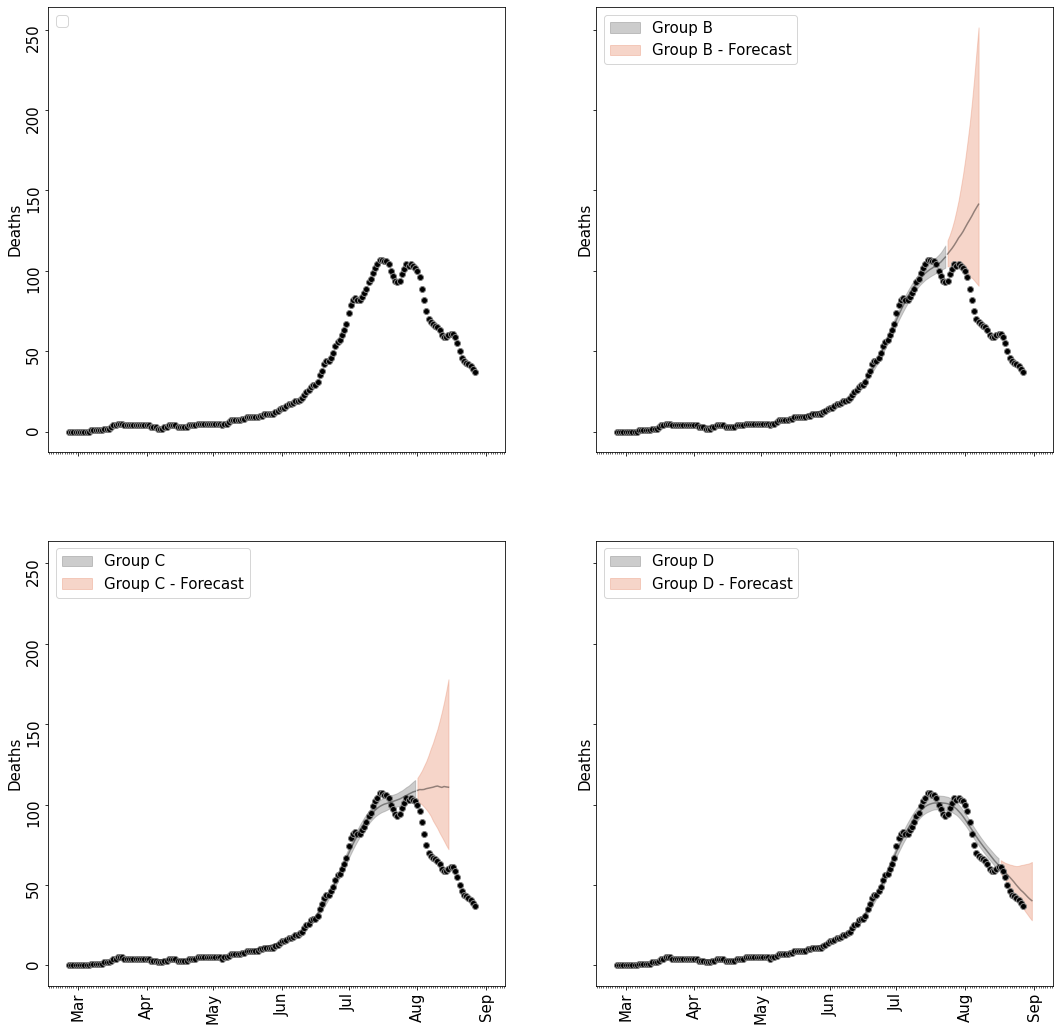

In [36]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

fig, axes = plt.subplots(2, 2, figsize=(18, 18), sharex=True, sharey=True)


deaths_df_B_fit = deaths_df_B[deaths_df_B["type"]=="estimate"]
axes[0,1].fill_between(deaths_df_B_fit["date"], deaths_df_B_fit["low_50"], deaths_df_B_fit["high_50"], color='gray', alpha=0.4, label='Group B')
axes[0,1].plot(deaths_df_B_fit["date"], deaths_df_B_fit["median"], color='black', alpha=0.4)

deaths_df_B_forecast = deaths_df_B[deaths_df_B["type"]=="forecast"]
deaths_df_B_forecast = deaths_df_B_forecast.iloc[:15]
axes[0,1].plot(deaths_df_B_forecast["date"], deaths_df_B_forecast["median"], color='black', alpha=0.4)
axes[0,1].fill_between(deaths_df_B_forecast["date"], deaths_df_B_forecast["low_50"], deaths_df_B_forecast["high_50"], color='darksalmon', alpha=0.4, label='Group B - Forecast')

deaths_df_C_fit = deaths_df_C[deaths_df_C["type"]=="estimate"]
axes[1,0].fill_between(deaths_df_C_fit["date"], deaths_df_C_fit["low_50"], deaths_df_C_fit["high_50"], color='gray', alpha=0.4, label='Group C')
axes[1,0].plot(deaths_df_C_fit["date"], deaths_df_C_fit["median"], color='black', alpha=0.4)

deaths_df_C_forecast = deaths_df_C[deaths_df_C["type"]=="forecast"]
deaths_df_C_forecast = deaths_df_C_forecast.iloc[:15]
axes[1,0].plot(deaths_df_C_forecast["date"], deaths_df_C_forecast["median"], color='black', alpha=0.4)
axes[1,0].fill_between(deaths_df_C_forecast["date"], deaths_df_C_forecast["low_50"], deaths_df_C_forecast["high_50"], color='darksalmon', alpha=0.4, label='Group C - Forecast')


deaths_df_D_fit = deaths_df_D[deaths_df_D["type"]=="estimate"]
axes[1,1].fill_between(deaths_df_D_fit["date"], deaths_df_D_fit["low_50"], deaths_df_D_fit["high_50"], color='gray', alpha=0.4, label='Group D')
axes[1,1].plot(deaths_df_D_fit["date"], deaths_df_D_fit["median"], color='black', alpha=0.4)

deaths_df_D_forecast = deaths_df_D[deaths_df_D["type"]=="forecast"]
deaths_df_D_forecast = deaths_df_D_forecast.iloc[:15]
axes[1,1].plot(deaths_df_D_forecast["date"], deaths_df_D_forecast["median"], color='black', alpha=0.4)
axes[1,1].fill_between(deaths_df_D_forecast["date"], deaths_df_D_forecast["low_50"], deaths_df_D_forecast["high_50"], color='darksalmon', alpha=0.4, label='Group D - Forecast')


for idx, ax in enumerate(axes.flatten()):
    loc = lockdowns[-1]
    data = bog_agg_df.loc[:loc["end_date"]][["smoothed_confirm", "smoothed_deaths"]].rename(columns={"smoothed_confirm": "confirmed", "smoothed_deaths": "death"})
    ax.scatter(data.index.values, data["death"], facecolor='k', edgecolor="gray")

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.tick_params(which='both', axis='both', labelrotation=90, labelsize=15)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    ax.set_ylabel('Deaths', size=15)
    ax.legend(loc='upper left', fontsize=15)

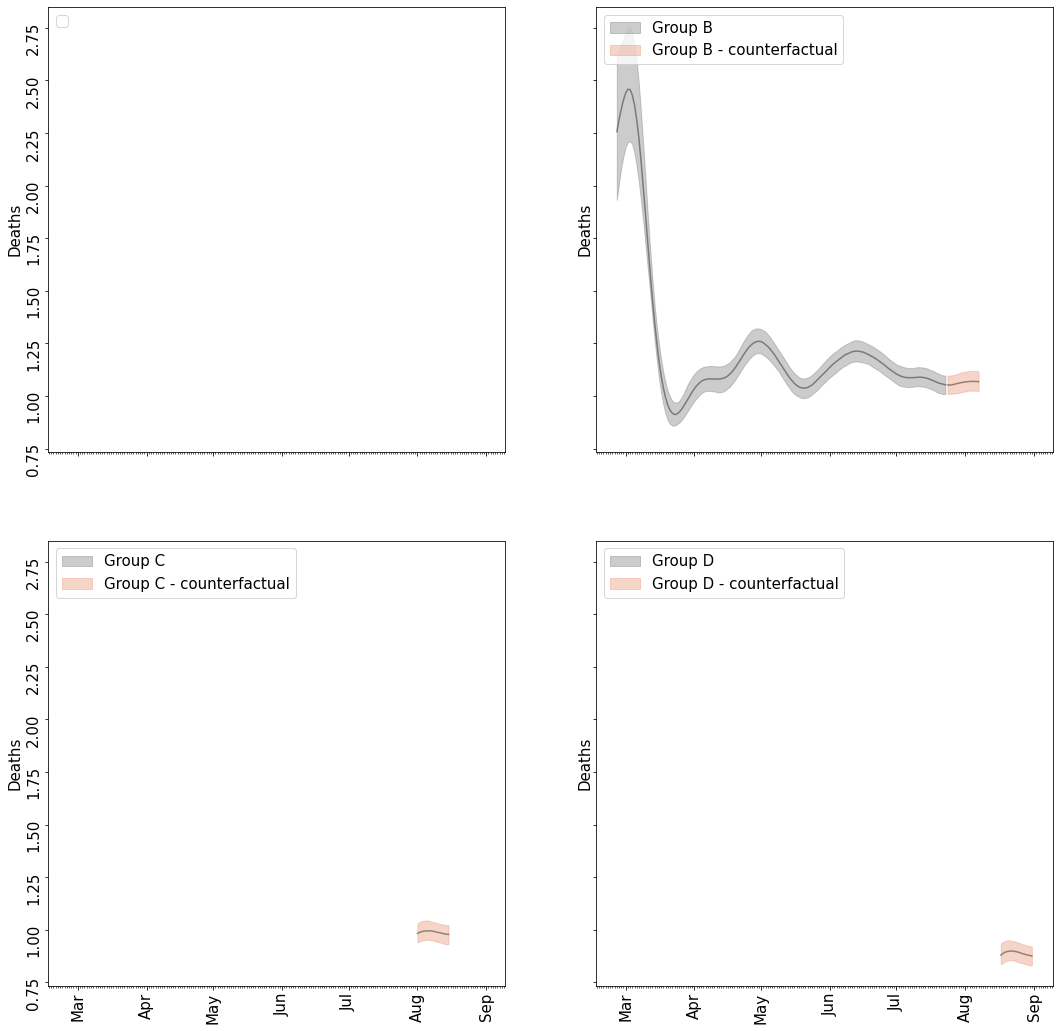

In [38]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

fig, axes = plt.subplots(2, 2, figsize=(18, 18), sharex=True, sharey=True)


rt_df_B_fit = rt_median_df_B[rt_median_df_B["type_id"]=="data"]
axes[0,1].fill_between(rt_df_B_fit["date"], rt_df_B_fit["lower_90"], rt_df_B_fit["upper_90"], color='gray', alpha=0.4, label='Group B')
axes[0,1].plot(rt_df_B_fit["date"], rt_df_B_fit["median"], color='black', alpha=0.4)

rt_df_B_counterfactual = rt_median_df_B[rt_median_df_B["type_id"]=="counterfactual"]
rt_df_B_counterfactual = rt_df_B_counterfactual.iloc[:15]
axes[0,1].plot(rt_df_B_counterfactual["date"], rt_df_B_counterfactual["median"], color='black', alpha=0.4)
axes[0,1].fill_between(rt_df_B_counterfactual["date"], rt_df_B_counterfactual["lower_90"], rt_df_B_counterfactual["upper_90"], color='darksalmon', alpha=0.4, label='Group B - counterfactual')

rt_df_C_fit = rt_df_C[rt_df_C["type_id"]=="estimate"]
axes[1,0].fill_between(rt_df_C_fit["date"], rt_df_C_fit["lower_90"], rt_df_C_fit["upper_90"], color='gray', alpha=0.4, label='Group C')
axes[1,0].plot(rt_df_C_fit["date"], rt_df_C_fit["median"], color='black', alpha=0.4)

rt_df_C_counterfactual = rt_df_C[rt_df_C["type_id"]=="counterfactual"]
rt_df_C_counterfactual = rt_df_C_counterfactual.iloc[:15]
axes[1,0].plot(rt_df_C_counterfactual["date"], rt_df_C_counterfactual["median"], color='black', alpha=0.4)
axes[1,0].fill_between(rt_df_C_counterfactual["date"], rt_df_C_counterfactual["lower_90"], rt_df_C_counterfactual["upper_90"], color='darksalmon', alpha=0.4, label='Group C - counterfactual')

rt_df_D_fit = rt_df_D[rt_df_D["type_id"]=="estimate"]
axes[1,1].fill_between(rt_df_D_fit["date"], rt_df_D_fit["lower_90"], rt_df_D_fit["upper_90"], color='gray', alpha=0.4, label='Group D')
axes[1,1].plot(rt_df_D_fit["date"], rt_df_D_fit["median"], color='black', alpha=0.4)

rt_df_D_counterfactual = rt_df_D[rt_df_D["type_id"]=="counterfactual"]
rt_df_D_counterfactual = rt_df_D_counterfactual.iloc[:15]
axes[1,1].plot(rt_df_D_counterfactual["date"], rt_df_D_counterfactual["median"], color='black', alpha=0.4)
axes[1,1].fill_between(rt_df_D_counterfactual["date"], rt_df_D_counterfactual["lower_90"], rt_df_D_counterfactual["upper_90"], color='darksalmon', alpha=0.4, label='Group D - counterfactual')


for idx, ax in enumerate(axes.flatten()):

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.tick_params(which='both', axis='both', labelrotation=90, labelsize=15)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    ax.set_ylabel('Deaths', size=15)
    ax.legend(loc='upper left', fontsize=15)